<a href="https://colab.research.google.com/github/douglascm/ml_analysis_reference/blob/main/ML_Pipeline_Template.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Machine Learning Pipeline

When it comes to building a machine learning from scratch there is recipe that can help facilitate the process and provide a guide for data scientist. This writeup aims to define one and guide it through with an example model. The tools selected is google colab for ease of reproduction.

Steps are as follow:

1.   Define the Problem and Set Objectives
2.   Gather and Prepare the Data
3.   Perform Exploratory Data Analysis (EDA)
4.   Feature Engineering
5.   Select a Machine Learning Algorithm
6.   Train and Evaluate Model Performance
7.   Model Optimization and Tuning
8.   Validate the Model
9.   Deploy

# Step 1 - Define the problem and set objectives

Clearly define the problem you want to solve with machine learning.
Set specific objectives and success criteria for your model. The problem selected for the present analysis is to create a model that is able to suggest the sale price of used cars for a dealership.

# Step 2 - Gather and Prepare the Data

Identify the relevant data sources and collect the necessary data.
Preprocess the data by cleaning, transforming, and normalizing it as needed.

The data selected for training this assignment is `car_price_train.csv`. So onto reading the data:



In [1]:
import pandas as pd
import numpy as np
from google.colab import drive

drive.mount('/content/drive',force_remount=True)
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/datasets/car_prices/car_price_train.csv')

df.head(3)

Mounted at /content/drive


,carID,brand,model,year,transmission,mileage,fuelType,tax,mpg,engineSize,target
0,14266,vauxhall,GTC,2018,Manual,4646,Petrol,145.0,36.2,2.0,19998
1,15238,ford,Grand Tourneo Connect,2015,Manual,94362,Diesel,125.0,58.9,1.6,9490
2,13982,vw,Tiguan Allspace,2019,Automatic,6580,Diesel,145.0,39.2,2.0,31990


Previosly we can see the the first 3 rows of the dataset. The columns and their definitions for this dataset are as follow:

```
* carID - numeric: identifier
* brand - string: car brand
* model - string: car model
* year - numeric: model year
* transmission - string: type of transmission (Manual, Automatic)
* mileage - numeric: total mileage
* fuelType - string: fuel type
* tax - numeric: tax amount
* mpg - numeric: miles per gallon
* engineSize - numeric: engile size in liters
* target - numeric: sell price in USD
```






In [ ]:
df.info()

The dataset contains `df.shape (3968, 11)` rows and columns. Now onto some exploratory data anaysis.

# Step 3 - Exploratory data analysis

This step consists of an analysis of the data to gain insights and understanding. Visualize the data using plots, histograms, and statistical measures. Identify any missing values, outliers, or data quality issues. Onto looking at the data

In [ ]:
df.describe()

,carID,year,mileage,tax,mpg,engineSize,target
count,3968.000000,3968.000000,3968.000000,3968.000000,3968.000000,3968.000000,3968.000000
mean,15830.915827,2016.691784,25347.024446,152.483619,50.334955,2.125126,23309.007812
std,2200.751077,2.908401,24620.999153,83.738882,35.373234,0.788259,16288.551889
min,12002.000000,1997.000000,1.000000,0.000000,2.800000,0.000000,450.000000
25%,13953.500000,2016.000000,5930.000000,145.000000,38.700000,1.600000,11994.000000
50%,15807.500000,2017.000000,19550.000000,145.000000,47.100000,2.000000,18995.000000
75%,17750.750000,2019.000000,37317.750000,150.000000,54.300000,2.500000,29998.000000
max,19629.000000,2020.000000,259000.000000,580.000000,470.800000,6.600000,145000.000000


In [ ]:
(100 * (df.isnull().sum() / len(df))).to_frame('per_null')

,per_null
carID,0.0
brand,0.0
model,0.0
year,0.0
transmission,0.0
mileage,0.0
fuelType,0.0
tax,0.0
mpg,0.0
engineSize,0.0


We can see that we dont have null variables and a few aggregates for numeric columns. Some models require that we don't have any missing values, as such they come with methods for inputting data, this will be explored further.

In [ ]:
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']

cat_vars = df.select_dtypes(include='object').columns.tolist()
num_vars = df[df.columns.difference(['carID','year'])].select_dtypes(include=numerics).columns.tolist()


df[cat_vars].nunique().to_frame('nunique')

,nunique
brand,9
model,90
transmission,3
fuelType,5


For the categorical variables, model has the highest amount of unique values. Now onto correlation analysis:

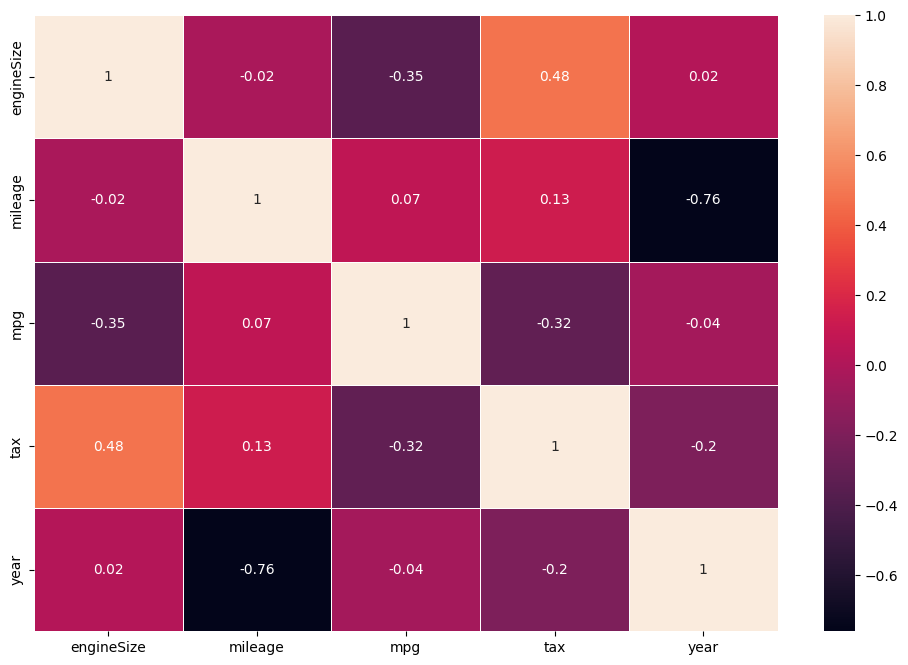

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.subplots(figsize=(12, 8))
sns.heatmap(df[df.columns.difference(['target','carID'])].corr(numeric_only=True).round(2), annot=True, linewidths=.5);

It seems that there is a high correlation between year with mileage, and tax with mpg, which are both expected. A pairsplot of the database can help find additional insights on the data and its behaviour:

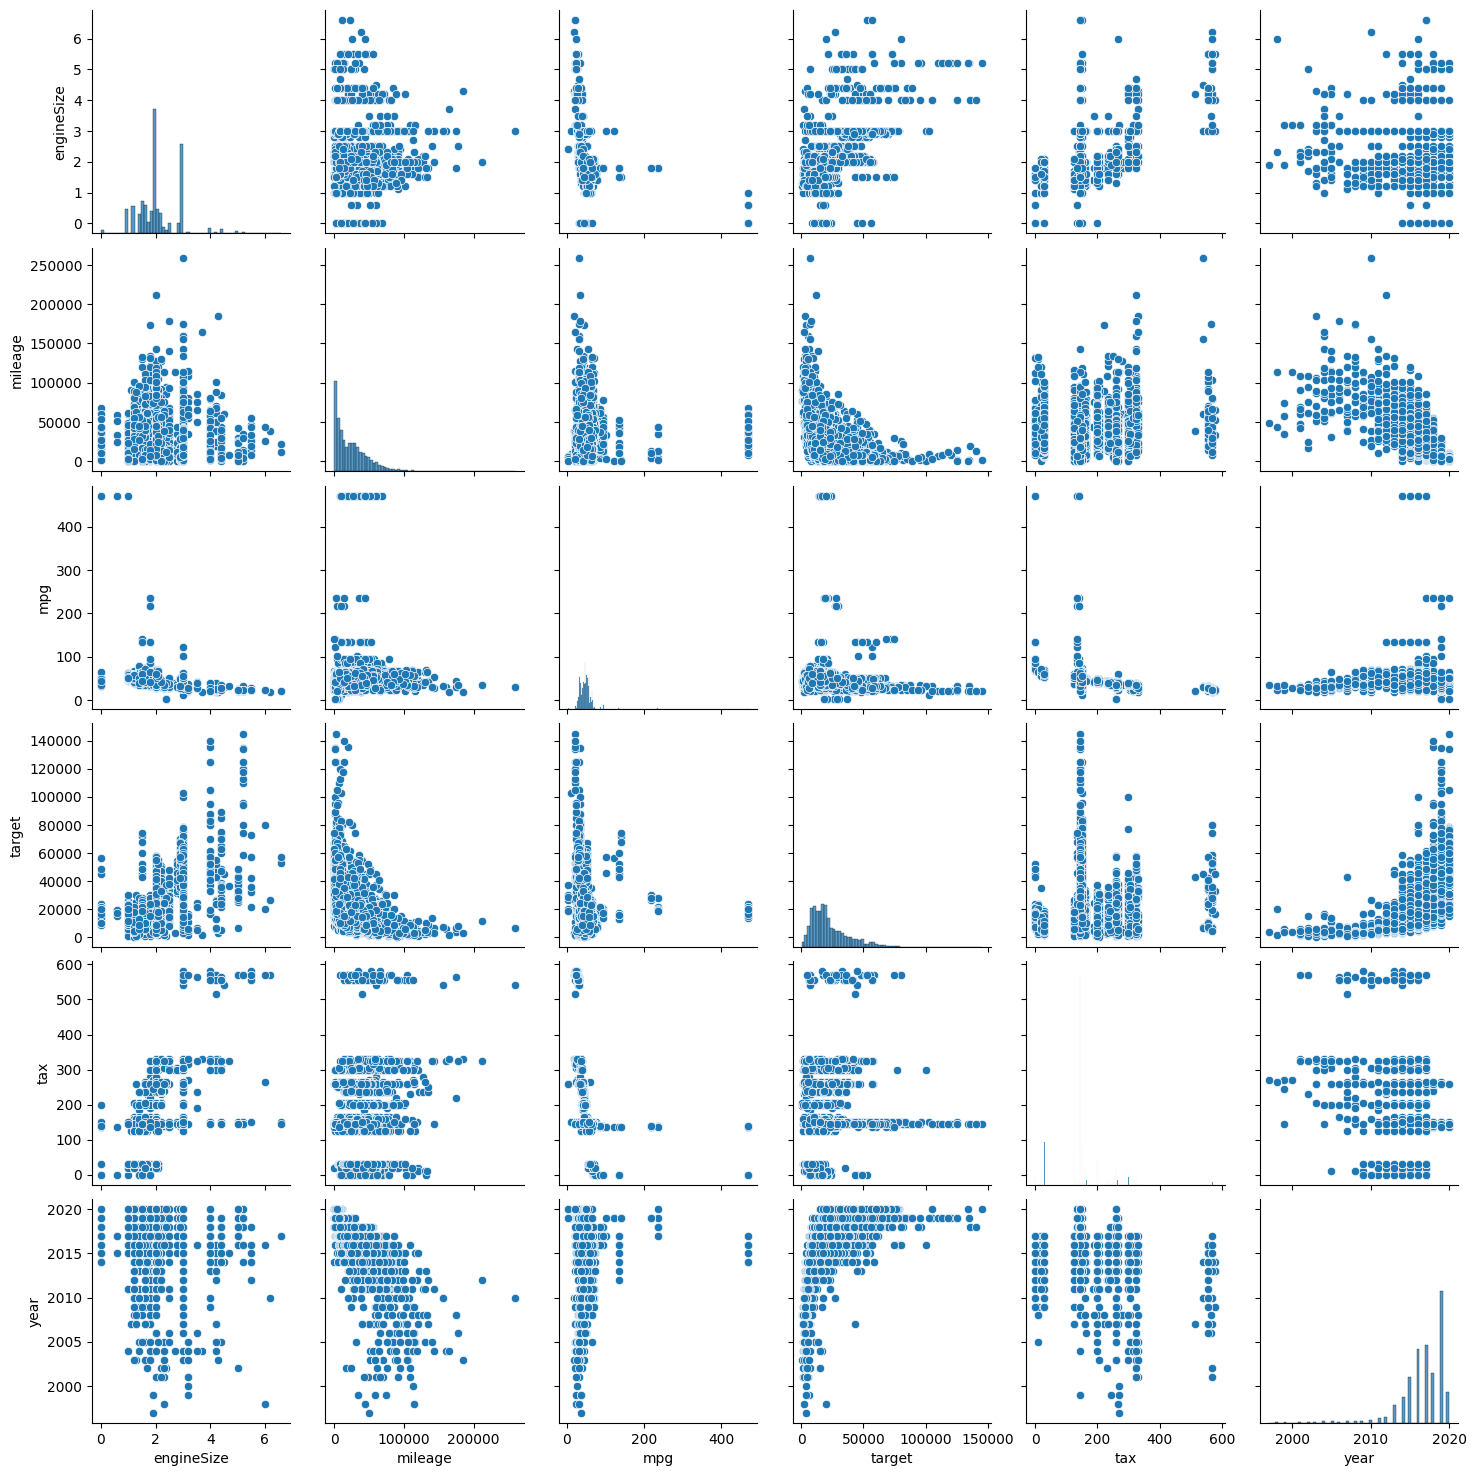

In [ ]:
import seaborn as sns

%matplotlib inline
sns.pairplot(df[df.columns.difference(['carID'])])

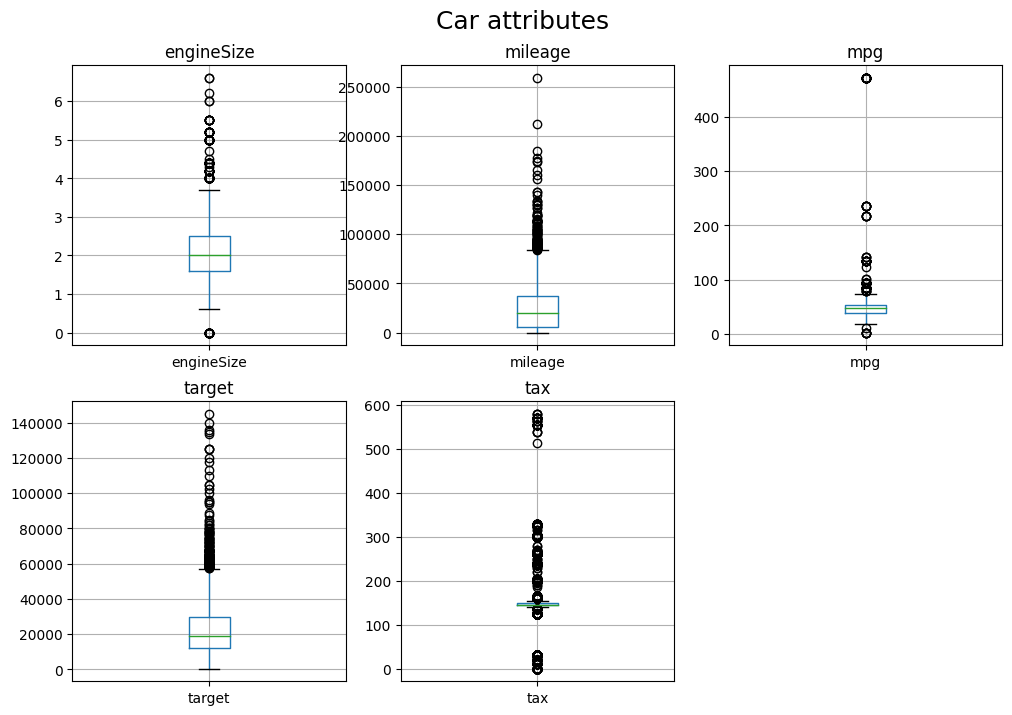

In [ ]:
plt.figure(figsize=(12, 8))
plt.subplots_adjust(hspace=0.2)
plt.suptitle("Car attributes", fontsize=18, y=0.95)

ncols = 3
nrows = len(num_vars) // ncols + (len(num_vars) % ncols > 0)

for n, col in enumerate(num_vars):
    ax = plt.subplot(nrows, ncols, n + 1)

    df.boxplot(column=col, ax=ax)

    ax.set_title(col)
    ax.set_xlabel("")

Looking at outliers it appears to be a few records for mileage and mpg that could have high leverage when building a model, in the feature engineering step we could study methods into grouping outliers such as defining mileage thresholds and new attributes for, as an example, `high_mileage_flag` and `high_mpg_flag`. Next a look into the price behaviour for categorical attributes.

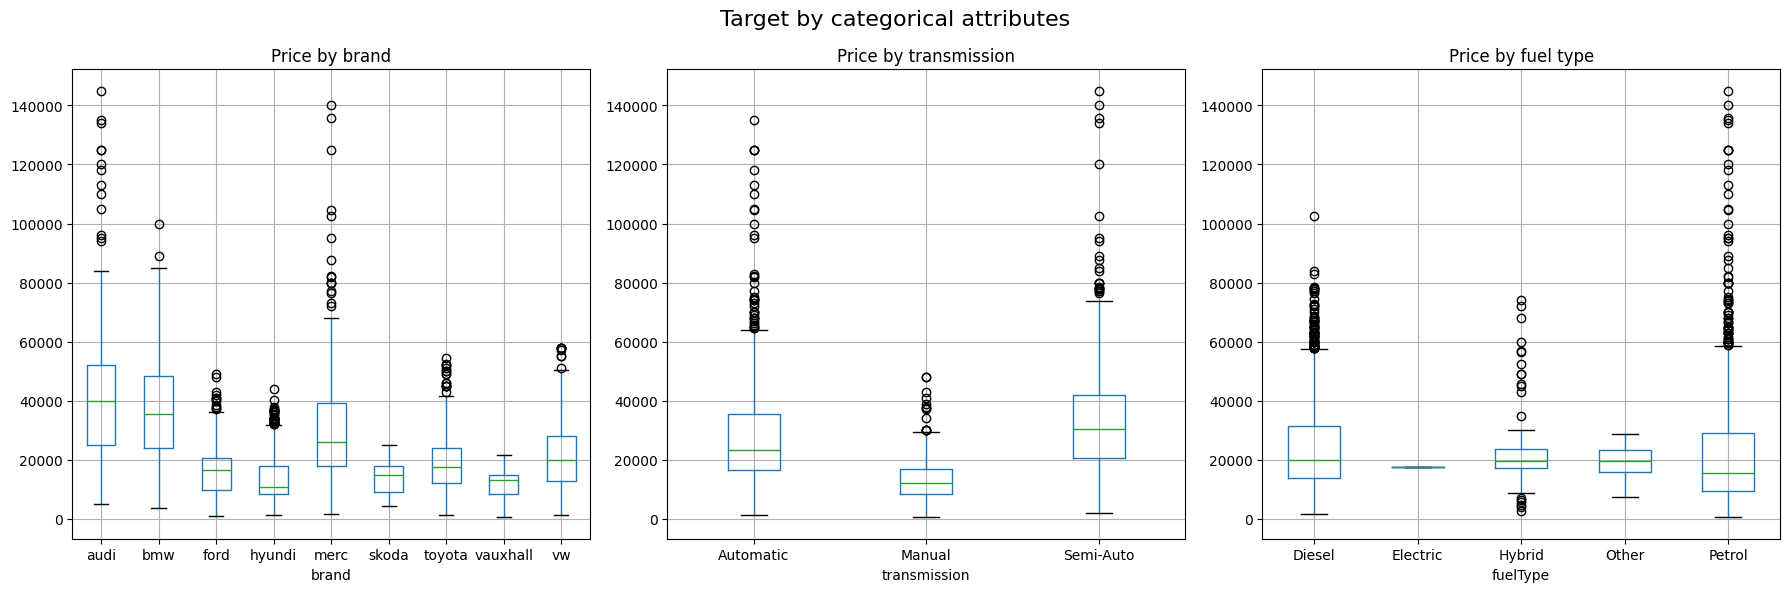

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(18,6))

df.boxplot(column='target', by='brand', ax=ax1)
df.boxplot(column='target', by='transmission', ax=ax2)
df.boxplot(column='target', by='fuelType', ax=ax3)

ax1.set_title('Price by brand')
ax2.set_title('Price by transmission')
ax3.set_title('Price by fuel type')

fig.suptitle("Target by categorical attributes", fontsize=16)
fig.tight_layout()

plt.show()

Ending with some insight into categories and their prevelances across other categories.

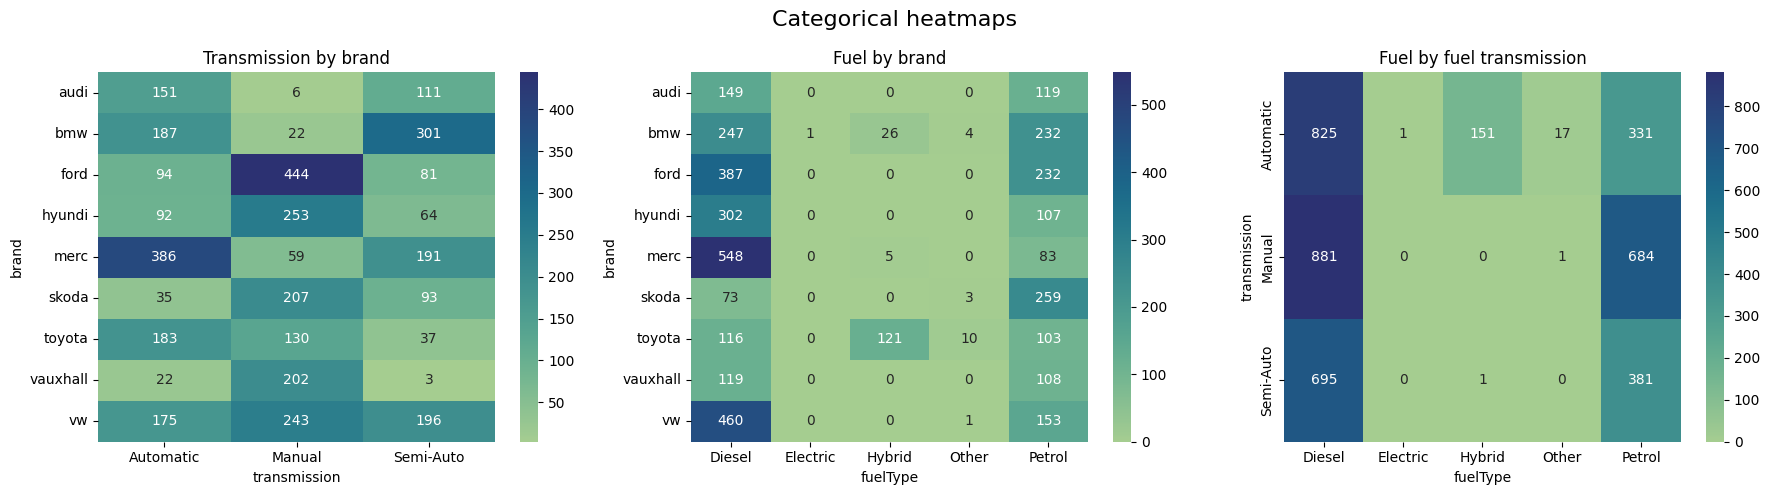

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(18,5))

tbl_brand_trans = pd.crosstab(df.brand, df.transmission)
tbl_brand_fuel = pd.crosstab(df.brand, df.fuelType)
tbl_fuel_trans = pd.crosstab(df.transmission, df.fuelType)

sns.heatmap(tbl_brand_trans, annot=True, cmap='crest', fmt="d",ax=ax1)
sns.heatmap(tbl_brand_fuel, annot=True, cmap='crest', fmt="d",ax=ax2)
sns.heatmap(tbl_fuel_trans, annot=True, cmap='crest', fmt="d",ax=ax3)

ax1.set_title('Transmission by brand')
ax2.set_title('Fuel by brand')
ax3.set_title('Fuel by fuel transmission')

fig.suptitle("Categorical heatmaps", fontsize=16)
fig.tight_layout()

plt.show()

# Step 4 - Feature Engineering

In [2]:
# instalando o pacote feature-engine
!pip install feature-engine

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 326.6/326.6 kB 9.9 MB/s eta 0:00:00


In this step we select or create appropriate features from the available data.
Apply techniques like feature scaling, dimensionality reduction, or encoding categorical variables. As previously mentioned, an additional method `OutlierTransform()` is defined in order to test the model with outliers being split into a new attribute.

In [3]:
key_vars = ['carID']
num_vars = ['mileage', 'tax', 'mpg', 'engineSize']
cat_vars = ['brand', 'model', 'transmission', 'fuelType']
target = 'target'

features = cat_vars + num_vars

X = df[features].copy()
y = df[target].copy()

from feature_engine.imputation import MeanMedianImputer, ArbitraryNumberImputer, CategoricalImputer
from feature_engine.wrappers import SklearnTransformerWrapper
from feature_engine.encoding import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin

def quantile_cut(X,per_thresh=0.9,flag=False):
  quant = X.quantile(per_thresh)
  if flag:
    return np.where(X > quant, 1, 0)
  else:
    return np.where(X > quant, quant, X)

class OutlierTransform(BaseEstimator, TransformerMixin):
  def __init__ (self, per_thresh = 0.9):
    self.per_thresh = per_thresh
  def fit(self,X,y=None):
    return self
  def transform(self, X, y=None):
    X['high_mpg_flag'] = quantile_cut(X['mpg'],per_thresh=self.per_thresh,flag=True)
    X['high_mileage_flag'] = quantile_cut(X['mileage'],per_thresh=self.per_thresh,flag=True)
    X['mpg'] = quantile_cut(X['mpg'],per_thresh=self.per_thresh)
    X['mileage'] = quantile_cut(X['mileage'],per_thresh=self.per_thresh)
    return X

steps_linear_models = [
    ('numeric_imputer', MeanMedianImputer(variables=num_vars, imputation_method='median')),
    ('attribs_adder', OutlierTransform()),
    ('categorical_imputer', CategoricalImputer(variables=cat_vars , fill_value='not_av')),
    ('std_scaler', SklearnTransformerWrapper(transformer=StandardScaler(), variables=num_vars)),
    ('ohe', OneHotEncoder(variables=cat_vars)),
]

steps_non_linear_models = [
    ('numeric_imputer', MeanMedianImputer(variables=num_vars, imputation_method='median')),
    ('attribs_adder', OutlierTransform()),
    ('categorical_imputer', CategoricalImputer(variables=cat_vars , fill_value='not_av')),
    ('ohe', OneHotEncoder(variables=cat_vars)),
]

# Step 5 - Select a machine learning algorithm


In [4]:
!pip install lightgbm xgboost catboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.6/98.6 MB 8.5 MB/s eta 0:00:00



In this step whoose a suitable algorithm based on the problem type (classification, regression, clustering, etc.). Consider factors such as model complexity, interpretability, and scalability. The defined problem requires a  regression, since the target is a continuous variable. As such, for the present assignment the following algorithms are tested:

- LinearRegression
- SGDRegressor
- SVR
- DecisionTreeRegressor
- RandomForestRegressor
- GradientBoostingRegressor
- XGBRegressor
- LGBMRegressor
- XGBRegressor
- CatBoostRegressor


In [5]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import SGDRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor

linear_models = [
    ('lr', LinearRegression()),
    ('sgd', SGDRegressor()),
    ('svr', SVR()),
]

non_linear_models = [
    ('dt', DecisionTreeRegressor(random_state=42)),
    ('dt_reg', DecisionTreeRegressor(random_state=42, max_depth=5)),
    ('rf', RandomForestRegressor(random_state=42)),
    ('gb', GradientBoostingRegressor(random_state=42)),
    ('lgbm', LGBMRegressor(random_state=42)),
    ('xgb', XGBRegressor(random_state=42)),
    ('cat', CatBoostRegressor(random_state=42,verbose=False)),
]

# 6 - Train and Evaluate Model Performance

Split the training set into input features and target variables. Fit the models to the training data using the chosen algorithms. Compute metrics to select the top performing models.



In [9]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## 6.1 - Train and Evaluate Assorted Models

In this step we select a couple of best performing models based on pre-defined metrics. For this step the metrics selected are ones appropriate for regression models:
- RMSE: root mean squared error
- MAE: mean absolute error
- MAPE: mean absolute percent

In [ ]:
# (classifier metrics) accuracy_score, balanced_accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, ConfusionMatrixDisplay, RocCurveDisplay, classification_report
# (regressor metrics) r2_score, mean_squared_error, mean_absolute_error, median_absolute_error, mean_absolute_percentage_error, max_error, mean_squared_log_error
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_validate

def RunExperiments(models, data_pipe, X_train , y_train , X_test , y_test):

  dfs = []
  for model in models:
    estimator = Pipeline(steps = data_pipe + [model])
    clf = estimator.fit(X_train, y_train)
    y_pred_test = estimator.predict(X_test)
    rmse_test = mean_squared_error(y_test, y_pred_test, squared=False)
    mae_test = mean_absolute_error(y_test, y_pred_test)
    mape_test = mean_absolute_percentage_error(y_test, y_pred_test)

    y_pred_train = estimator.predict(X_train)
    rmse_train = mean_squared_error(y_train, y_pred_train, squared=False)
    mae_train = mean_absolute_error(y_train, y_pred_train)
    mape_train = mean_absolute_percentage_error(y_train, y_pred_train)

    df = pd.DataFrame({"algorithm":  np.repeat(model[0],2)
                            ,"base": ['test','train']
                            ,"rmse": [rmse_test,rmse_train]
                            ,"mae": [mae_test,mae_train]
                            ,"mape": [mape_test,mape_train]})

    dfs.append(df)

  df_final = pd.concat(dfs, ignore_index=True)
  return df_final

In [ ]:
pd.options.display.float_format = '{:.4f}'.format
import warnings
warnings.filterwarnings('ignore')

linear_results = RunExperiments(linear_models, steps_linear_models, X_train, y_train,X_test,y_test)
non_linear_results = RunExperiments(non_linear_models, steps_non_linear_models, X_train, y_train,X_test,y_test)

In [ ]:
linear_results.sort_values(by=['base','mae'])

,algorithm,base,rmse,mae,mape
0,lr,test,6149.9074,3919.8665,0.2668
2,sgd,test,5931.8343,4014.5006,0.2777
4,svr,test,16698.8262,11772.5131,0.7505
1,lr,train,5520.8467,3650.4212,0.2300
3,sgd,train,5902.4090,3872.8337,0.2503
5,svr,train,16731.4488,11169.6189,0.6801


In [ ]:
non_linear_results.sort_values(by=['base','mae'])

,algorithm,base,rmse,mae,mape
12,cat,test,4031.7590,2424.2178,0.1541
10,xgb,test,4340.9017,2506.9904,0.1480
4,rf,test,4453.4986,2567.3458,0.1486
8,lgbm,test,4738.6393,2811.2006,0.1861
0,dt,test,5676.5064,3117.0230,0.1649
6,gb,test,5344.2047,3484.3937,0.2391
2,dt_reg,test,7897.0453,5106.3225,0.3201
1,dt,train,387.3453,66.5733,0.0053
5,rf,train,1646.0215,921.8252,0.0535
11,xgb,train,1875.3093,1314.2102,0.0761


Out of all the algorithms tested, XGBRegressor and CatBoostRegressor had the best performance.

In [6]:
selected_models = [
    ('xgb', XGBRegressor(random_state=42)),
    ('cat', CatBoostRegressor(random_state=42,verbose=False)),
]

## 6.2 - Cross Validation

For evaluating model performance there is the k-folds cross-validation method. The method can randomly split the training data into distinct subsets called *folds*, then train and evaluate the model, choosing everytime one different fold for testing and the remaining for training.


In [11]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_validate

metrics = [
    'neg_mean_absolute_error'
]

def RunExperiments(models, data_pipe, metrics, X_train , y_train , X_test , y_test):

  dfs = []
  for model in models:
    kfold = KFold(n_splits=5, shuffle=True, random_state=42)
    estimator = Pipeline(steps = data_pipe + [model])
    cv_results = cross_validate(
        estimator = estimator,
        X=X_train,
        y=y_train,
        cv=kfold,
        scoring=metrics,
        n_jobs=-1)

    df_train = pd.DataFrame(cv_results)
    df_train['algorithm'] = model[0]
    df_train = df_train.groupby(['algorithm']).agg(
          mae=('test_neg_mean_absolute_error', 'mean'),
          sd_mae=('test_neg_mean_absolute_error', 'std'),
          ).reset_index()

    dfs.append(df_train)

  df_final = pd.concat(dfs, ignore_index=True)
  return df_final

In [ ]:
selected_validation = RunExperiments(selected_models, steps_non_linear_models, metrics, X_train, y_train, X_test, y_test)
selected_validation


,algorithm,mae,sd_mae
0,xgb,-2535.2725,157.9331
1,cat,-2392.6923,97.9862


## 6.3 - Optimizing **Hyperparameters**

In this step we have a reduced selection of promissing models, and now can improve its performance by optimizing its hyperparameters.

## XGBoost

In [ ]:
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe, space_eval
from hyperopt.pyll.base import scope

xgb_param_grid = {'max_depth': scope.int(hp.quniform("max_depth", 1, 5, 1)),
        'gamma': hp.uniform ('gamma', 0,1),
        'reg_alpha' : hp.uniform('reg_alpha', 0,50),
        'reg_lambda' : hp.uniform('reg_lambda', 10,100),
        'colsample_bytree' : hp.uniform('colsample_bytree', 0,1),
        'min_child_weight' : hp.uniform('min_child_weight', 0, 5),
        'n_estimators': 1000,
        'learning_rate': hp.uniform('learning_rate', 0, .15),
        'random_state': 5,
        'max_bin' : scope.int(hp.quniform('max_bin', 200, 550, 1))}

def xgb_hyperparameter_tuning(space):
    algo = [
        ('xgb',XGBRegressor(**space))
    ]

    model = Pipeline(steps = steps_non_linear_models + algo)

    data_pipe = Pipeline(steps = steps_non_linear_models)

    X_train_trans = data_pipe.fit_transform(X_train,y_train)
    X_test_trans = data_pipe.transform(X_test)

    #Define evaluation datasets.
    evaluation = [(X_train_trans, y_train), (X_test_trans, y_test)]

    #Fit the model. Define evaluation sets, early_stopping_rounds, and eval_metric.
    model.fit(X_train, y_train, xgb__eval_set=evaluation, xgb__eval_metric="mae", xgb__early_stopping_rounds=100,xgb__verbose=False)

    #Obtain prediction and mae score.
    pred = model.predict(X_test)
    mae = mean_absolute_error(y_test, pred)
    print (f"SCORE: {mae}")

    #Specify what the loss is for each model.
    return {'loss': mae, 'status': STATUS_OK, 'model': model}

trials = Trials()
xgb_best = fmin(fn=xgb_hyperparameter_tuning,
            space=xgb_param_grid,
            algo=tpe.suggest,
            max_evals=20,
            trials=trials)

print(xgb_best)

xgb_best_model = trials.results[np.argmin([r['loss'] for r in
    trials.results])]['model']

SCORE: 3101.521511740889
SCORE: 3019.72796892219
SCORE: 4749.1484182823815
SCORE: 3166.3857661710877
SCORE: 2865.6424708138184
SCORE: 4176.240423092014
SCORE: 3929.4663421092764
SCORE: 2665.2326755475638
SCORE: 2715.557585516865
SCORE: 3343.7454501903926
SCORE: 3133.6896219325604
SCORE: 2804.1966967834933
SCORE: 3076.881580420045
SCORE: 3004.6937489545617
SCORE: 2599.1462479214224
SCORE: 3259.726453958891
SCORE: 2953.0919024950313
SCORE: 2938.18252309804
SCORE: 2556.643966252017
SCORE: 17065.051814081686
100%|██████████| 20/20 [04:19<00:00, 12.98s/trial, best loss: 2556.643966252017]
{'colsample_bytree': 0.4734927353194692, 'gamma': 0.01858767692405716, 'learning_rate': 0.12427889366123009, 'max_bin': 445.0, 'max_depth': 5.0, 'min_child_weight': 4.037584327885021, 'reg_alpha': 28.501457060517094, 'reg_lambda': 39.81650513248472}


In [ ]:
xgb_hyperparams = space_eval(xgb_param_grid, xgb_best)
xgb_hyperparams

{'colsample_bytree': 0.4734927353194692,
 'gamma': 0.01858767692405716,
 'learning_rate': 0.12427889366123009,
 'max_bin': 445,
 'max_depth': 5,
 'min_child_weight': 4.037584327885021,
 'n_estimators': 1000,
 'random_state': 5,
 'reg_alpha': 28.501457060517094,
 'reg_lambda': 39.81650513248472}

In [ ]:
params = {'colsample_bytree': 0.47,
 'gamma': 0.019,
 'learning_rate': 0.12,
 'max_bin': 445,
 'max_depth': 5,
 'min_child_weight': 4.0,
 'n_estimators': 1000,
 'random_state': 5,
 'reg_alpha': 28.50,
 'reg_lambda': 39.82}

xgb_best_model = Pipeline(
  steps = steps_non_linear_models + [('xbg_best',XGBRegressor(**params))]
)

In [ ]:
xgb_best_model.fit(X_train,y_train)

xgb_preds_best = xgb_best_model.predict(X_test)
xgb_score_best = mean_absolute_error(y_test, xgb_preds_best)
print('MAE_Best_Model:', xgb_score_best)

xgb_standard = Pipeline(steps = steps_non_linear_models + [('xgb',XGBRegressor())]).fit(X_train, y_train)
standard_score = mean_absolute_error(y_test, xgb_standard.predict(X_test))
print('MAE_Standard_Model:', standard_score)

MAE_Best_Model: 2511.3530577844576
MAE_Standard_Model: 2506.990392728176


## CatBoost

In [ ]:
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe, space_eval
from hyperopt.pyll.base import scope

cat_param_grid = {'learning_rate': hp.uniform('learning_rate', 0.1, 0.5),
                'iterations': hp.randint('iterations',100,1000),
                'l2_leaf_reg': hp.randint('l2_leaf_reg',1,10),
                'depth': hp.randint('depth',4,10),
                'random_state': 5,
                'bootstrap_type' : hp.choice('bootstrap_type', ['Bayesian', 'Bernoulli'])}

def cat_hyperparameter_tuning(space):
    algo = [
        ('cat',CatBoostRegressor(**space, loss_function='MAE',
                              eval_metric='MAE',
                              early_stopping_rounds=100,))
    ]

    model = Pipeline(steps = steps_non_linear_models + algo)

    data_pipe = Pipeline(steps = steps_non_linear_models)

    X_train_trans = data_pipe.fit_transform(X_train,y_train)
    X_test_trans = data_pipe.transform(X_test)

    #Define evaluation datasets.
    evaluation = [(X_train_trans, y_train), (X_test_trans, y_test)]

    #Fit the model. Define evaluation sets, early_stopping_rounds, and eval_metric.
    model.fit(X_train, y_train, cat__eval_set=evaluation, cat__verbose=False)

    #Obtain prediction and mae score.
    pred = model.predict(X_test)
    mae = mean_absolute_error(y_test, pred)
    print (f"SCORE: {mae}")

    #Specify what the loss is for each model.
    return {'loss': mae, 'status': STATUS_OK, 'model': model}

trials = Trials()
cat_best = fmin(fn=cat_hyperparameter_tuning,
            space=cat_param_grid,
            algo=tpe.suggest,
            max_evals=20,
            trials=trials)

print(cat_best)

cat_best_model = trials.results[np.argmin([r['loss'] for r in
    trials.results])]['model']

SCORE: 2707.330054761461
SCORE: 2774.278906350856
SCORE: 2598.1691750259183
SCORE: 2661.5609615005264
SCORE: 2811.618854482846
SCORE: 2505.6101210555553
SCORE: 2505.358544713814
SCORE: 2777.8843365671637
SCORE: 2618.019529281603
SCORE: 2666.9088327253476
SCORE: 2660.6636000375297
SCORE: 2565.1379521988547
SCORE: 3141.837543125169
SCORE: 2589.068083442758
SCORE: 2653.4218945613843
SCORE: 2709.880642646986
SCORE: 2739.9585918413536
SCORE: 2421.008042004032
SCORE: 2750.0282433558423
SCORE: 2482.0538918214443
100%|██████████| 20/20 [00:46<00:00,  2.30s/trial, best loss: 2421.008042004032]
{'bootstrap_type': 0, 'depth': 7, 'iterations': 853, 'l2_leaf_reg': 8, 'learning_rate': 0.2061138955860755}


In [ ]:
cat_hyperparams = space_eval(cat_param_grid, cat_best)
cat_hyperparams

{'bootstrap_type': 'Bayesian',
 'depth': 7,
 'iterations': 853,
 'l2_leaf_reg': 8,
 'learning_rate': 0.2061138955860755,
 'random_state': 5}

In [7]:
cat_params = {'bootstrap_type': 'Bernoulli',
 'depth': 6,
 'iterations': 404,
 'l2_leaf_reg': 7,
 'random_state': 5,
 'learning_rate': 0.29}

cat_best_model = Pipeline(
  steps = steps_non_linear_models + [('cat_best',CatBoostRegressor(**cat_params,verbose=False))]
)

In [12]:
cat_best_model.fit(X_train,y_train, cat_best__verbose=False)

cat_preds_best = cat_best_model.predict(X_test)
cat_score_best = mean_absolute_error(y_test, cat_preds_best)
print('MAE_Best_Model:', cat_score_best)

cat_standard = Pipeline(steps = steps_non_linear_models + [('cat',CatBoostRegressor())]).fit(X_train, y_train, cat__verbose=False)
standard_score = mean_absolute_error(y_test, cat_standard.predict(X_test))
print('MAE_Standard_Model:', standard_score)

/usr/local/lib/python3.10/dist-packages/feature_engine/encoding/one_hot.py:277: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X[f"{feature}_{category}"] = np.where(X[feature] == category, 1, 0)
/usr/local/lib/python3.10/dist-packages/feature_engine/encoding/one_hot.py:277: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X[f"{feature}_{category}"] = np.where(X[feature] == category, 1, 0)
/usr/local/lib/python3.10/dist-packages/feature_engine/encoding/one_hot.py:277: PerformanceWarning: DataFrame is highly fragmented.  This is usual

MAE_Best_Model: 2389.466772393053
MAE_Standard_Model: 2392.5053966260703


/usr/local/lib/python3.10/dist-packages/feature_engine/encoding/one_hot.py:277: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X[f"{feature}_{category}"] = np.where(X[feature] == category, 1, 0)
/usr/local/lib/python3.10/dist-packages/feature_engine/encoding/one_hot.py:277: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X[f"{feature}_{category}"] = np.where(X[feature] == category, 1, 0)
/usr/local/lib/python3.10/dist-packages/feature_engine/encoding/one_hot.py:277: PerformanceWarning: DataFrame is highly fragmented.  This is usual

In [19]:
fi = pd.Series()
for f, n in zip(cat_best_model[-1].feature_importances_, cat_best_model[:-1].transform(X_train).columns):
    fi[n] = f
fi

<ipython-input-19-3c094ac2bcf2>:1: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  fi = pd.Series()
/usr/local/lib/python3.10/dist-packages/feature_engine/encoding/one_hot.py:277: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X[f"{feature}_{category}"] = np.where(X[feature] == category, 1, 0)
/usr/local/lib/python3.10/dist-packages/feature_engine/encoding/one_hot.py:277: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
 

mileage                   23.104753
tax                        8.005259
mpg                        9.958283
engineSize                30.798948
high_mpg_flag              0.013442
                            ...    
transmission_Automatic     0.341428
fuelType_Diesel            2.708201
fuelType_Petrol            1.077430
fuelType_Hybrid            1.109639
fuelType_Other             0.015903
Length: 112, dtype: float64

<Axes: >

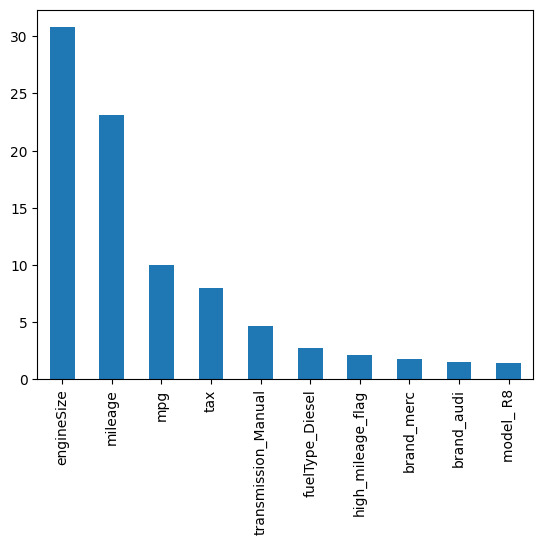

In [20]:
fi.sort_values(ascending=False)[:10].plot(kind='bar')

## 6.4 - Feature Selection

In [14]:
from feature_engine.selection import SelectByShuffling

shuffle = SelectByShuffling(estimator=cat_best_model[-1], scoring='neg_mean_absolute_error', cv=5)

data_pipe = Pipeline(steps = steps_non_linear_models)

X_train_transformed = data_pipe.fit_transform(X_train,y_train)
X_test_transformed = data_pipe.transform(X_test)

shuffle.fit(X_train_transformed, y_train)

/usr/local/lib/python3.10/dist-packages/feature_engine/encoding/one_hot.py:277: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X[f"{feature}_{category}"] = np.where(X[feature] == category, 1, 0)
/usr/local/lib/python3.10/dist-packages/feature_engine/encoding/one_hot.py:277: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X[f"{feature}_{category}"] = np.where(X[feature] == category, 1, 0)
/usr/local/lib/python3.10/dist-packages/feature_engine/encoding/one_hot.py:277: PerformanceWarning: DataFrame is highly fragmented.  This is usual

SelectByShuffling(cv=5,
                  estimator=<catboost.core.CatBoostRegressor object at 0x7f01c29749a0>,
                  scoring='neg_mean_absolute_error')

In [18]:
shuffle.

False

In [ ]:
print(f"Qtde de variáveis antes da remoção: {X_train_transformed.shape[1]}")
print(f"Qtde de variáveis a serem removidas: {len(shuffle.features_to_drop_)}")
print(f"Qtde de variáveis depois da remoção: {X_train_transformed.shape[1] - len(shuffle.features_to_drop_)}")

Qtde de variáveis antes da remoção: 113
Qtde de variáveis a serem removidas: 100
Qtde de variáveis depois da remoção: 13


In [ ]:
X_train_transformed_reduzido = shuffle.transform(X_train_transformed)
X_test_transformed_reduzido  = shuffle.transform(X_test_transformed)
sorted(X_train_transformed_reduzido)

['brand_audi',
 'brand_bmw',
 'brand_merc',
 'engineSize',
 'fuelType_Diesel',
 'fuelType_Petrol',
 'high_mileage_flag',
 'mileage',
 'model_ Caravelle',
 'model_ S Class',
 'mpg',
 'tax',
 'transmission_Manual']

In [ ]:
cat_best_model_reduced = cat_best_model[-1]

cat_best_model_reduced.fit(X_train_transformed_reduzido, y_train)

y_pred_train = cat_best_model_reduced.predict(X_train_transformed_reduzido)
y_pred_test  = cat_best_model_reduced.predict(X_test_transformed_reduzido)

mae_train = mean_absolute_error(y_train, y_pred_train)
mae_test = mean_absolute_error(y_test, y_pred_test)

print('MAE_Featured_Selected Train:', mae_train)
print('MAE_Featured_Selected Test:', mae_test)

MAE_Featured_Selected Train: 1709.1652189327372
MAE_Featured_Selected Test: 2712.0120029788113


# 7 - Evaluate Mode Performance

Use the validation set to assess the model's performance.
Measure relevant metrics such as accuracy, precision, recall, or mean squared error. Analyze and interpret the model's strengths and weaknesses.

In [ ]:
import pandas as pd
import numpy as np
from google.colab import drive

drive.mount('/content/drive',force_remount=True)

df_prod = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/datasets/car_prices/car_price_prod.csv')
df_prod.shape

Mounted at /content/drive


(992, 11)

In [ ]:
df_prod

,carID,brand,model,year,transmission,mileage,fuelType,tax,mpg,engineSize,target
0,13209,ford,Edge,2017,Automatic,30255,Diesel,165.0000,48.7000,2.0000,20500
1,15965,bmw,X4,2015,Automatic,95408,Diesel,145.0000,54.3000,2.0000,15199
2,14659,bmw,6 Series,2016,Automatic,32449,Diesel,160.0000,51.4000,3.0000,18450
3,12756,merc,S Class,2012,Automatic,72700,Diesel,235.0000,41.5000,3.0000,12995
4,13289,merc,V Class,2018,Automatic,15232,Diesel,145.0000,48.7000,2.1000,19750
...,...,...,...,...,...,...,...,...,...,...,...
987,17108,merc,X-CLASS,2018,Automatic,9500,Diesel,260.0000,31.4000,3.0000,36790
988,14859,merc,CLS Class,2017,Semi-Auto,27354,Diesel,160.0000,49.6000,3.0000,23998
989,12676,bmw,X6,2016,Semi-Auto,31585,Diesel,200.0000,47.1000,3.0000,28950
990,16387,toyota,Verso,2017,Semi-Auto,16084,Petrol,160.0000,43.5000,1.8000,15498


In [ ]:
X_prod = df_prod[features]

X_prod_transformed = data_pipe.transform(X_prod)
X_prod_transformed_reduzido = shuffle.transform(X_prod_transformed)

y_prod = df_prod[target]
y_pred_prod = cat_best_model_reduced.predict(X_prod_transformed_reduzido)

mae_prod = mean_absolute_error(y_prod, y_pred_prod)

print('MAE_Featured_Selected Prod:', mae_prod)


MAE_Featured_Selected Prod: 2064.685193512489
